# 1. Data Prepocessing

In [1]:
import pandas as pd

def int2str(x):
    if len(str(x)) == 1:
        return '0'+str(x)
    else:
        return str(x)

# read all files in one step
data = pd.read_excel('sp500.xlsx', None, index_col=0)
sheetsName = list(data.keys())
print('All sheet names in the excel are :\n', sheetsName)

sheetsName.extend(['gld', 'gspc'])

#  Iterate through each worksheet (each industry) and process data
for i, industry in enumerate(sheetsName):
    if industry not in ['gld', 'gspc']:
        # Extract data from each industry
        industry_data = data[industry]
        # Extract data from each company
        companys = industry_data.columns.values
    
        # Reset index, restore date column to normal column, non-index column
        industry_data = industry_data.reset_index()

    elif industry == 'gld':
        gld = pd.read_csv('GLD.csv')
        industry_data = gld[['index', 'Adj Close']]
        industry_data.columns = ['index', 'gld']
        companys = 'gld'

    elif industry == 'gspc':
        gspc = pd.read_csv('GSPC.csv')
        industry_data = gspc[['index', 'Adj Close']]
        industry_data.columns = ['index', 'gspc']
        companys = 'gspc'   
    
    # Change the data format of the date column to string
    industry_data['index'] = industry_data['index'].apply(str)
    if industry not in ['gld', 'gspc']:
        # Divide the date data of the string type into three columns according to the '-' year, month and day, and save them in the data frame date_split_df
        date_split_df = industry_data['index'].str.split('-', expand=True)
        # Rename the data_date_split_df column
        date_split_df.columns  = ['year',  'month', 'date']
    else:
        date_split_df = industry_data['index'].str.split('/', expand=True)
        # Rename the data_date_split_df column
        date_split_df.columns  = ['month',  'date', 'year']

    # Splice the data frame date_split_df with the original data frame industry_data
    industry_data = pd.concat([date_split_df, industry_data], axis=1)
    
    # Sort the spliced data frame industry_data by 'year' and 'month', and calculate the average value of each company's stock price after classification
    # Calculate the average stock price of each company in the industry within a month to represent the company's stock price in this month
    if industry not in ['gld', 'gspc']:
        industry_data_classify = industry_data.groupby(['year', 'month'])[companys].agg('mean')
    
        # Reset index, reset 'year' and 'month' to normal columns, non-index columns
        industry_data_classify = industry_data_classify.reset_index()
        
        # Calculate the monthly stock price of the industry (take the average of all companies in the month as the average stock price of the month)
        industry_data_classify[industry] = industry_data_classify[companys].mean(axis=1)
       
    else:
        industry_data_classify = industry_data.groupby(['year', 'month']).mean()
        industry_data_classify.columns = [industry]
        industry_data_classify = industry_data_classify.reset_index()
        industry_data_classify['year'] = industry_data_classify['year'].apply(int)
        industry_data_classify['month'] = industry_data_classify['month'].apply(int)
        industry_data_classify = industry_data_classify.sort_values(by = ['year', 'month'])
        industry_data_classify['year'] = industry_data_classify['year'].apply(str)
        industry_data_classify['month'] = industry_data_classify['month'].apply(int2str)
        #print(industry_data_classify)


    # Further calculation of the industry's monthly stock price growth rate
    industry_data_classify[industry] = industry_data_classify[industry].pct_change(1)

    
    # Extract the required data year, month, stock price growth rate
    industry_data_classify = industry_data_classify[['year', 'month', industry]]

    # After each processing, merge the data
    if i == 0:
        aggregation_data = industry_data_classify
    else:
        
        aggregation_data = pd.merge(aggregation_data, industry_data_classify, how='left', on=['year', 'month'])


# The aggregation_data data is saved in the output folder temp.csv file, for reference
aggregation_data.to_csv('temp.csv',  index=False)

# Generate pivot table based on raw data
data_aggregation  = pd.pivot_table(aggregation_data, index=['year', 'month'])
data_aggregation.T.to_csv('output.csv')
print('Data has been wrote to output.csv.')

All sheet names in the excel are :
 ['Communication Service', 'Consumer Discretionary', 'Consumer Staples', 'Financials', 'Energy', 'Industrials', 'Health Care', 'Information Technology', 'Materials', 'Real Estate', 'Utilities']
Data has been wrote to output.csv.


/Users/byzeng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# 2. Heat Map Visualization

Part A. 
1. Visualize the monthly percentage change of adj_close in 11 sectors, gold, and S&P 500 from May, 2018 to April, 2020. Determine sectors that have the most or least fluctuation over the selected period, and compare them to gold stock fluctuation.


In [2]:
# import packages
import pandas as pd
import numpy as np 
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
# read temp.csv
output_T = pd.read_csv('temp.csv')

# drop all NaN
output_T.dropna(inplace = True)

# drop month and year, and set inplace is true
output_T.drop('year', axis=1,inplace = True)
output_T.drop('month', axis=1,inplace = True)

# reset index
output_T.reset_index(inplace = True)
output_T.drop('index', axis =1, inplace = True)

In [4]:
# Set up for heat map from 2018-2020
Cols=output_T.columns[:]# keep all columns 

ncols = len(Cols)
# The heatmap color scheme depends on the column
# For each column, Green color represents percentage greater than 0, red color represents percentage less than 0.
# And the different shade measures the degree 
cmaps = ["RdYlGn", "RdYlGn", "RdYlGn", "RdYlGn", "RdYlGn", "RdYlGn","RdYlGn","RdYlGn",
         "RdYlGn","RdYlGn","RdYlGn","RdYlGn","RdYlGn"]


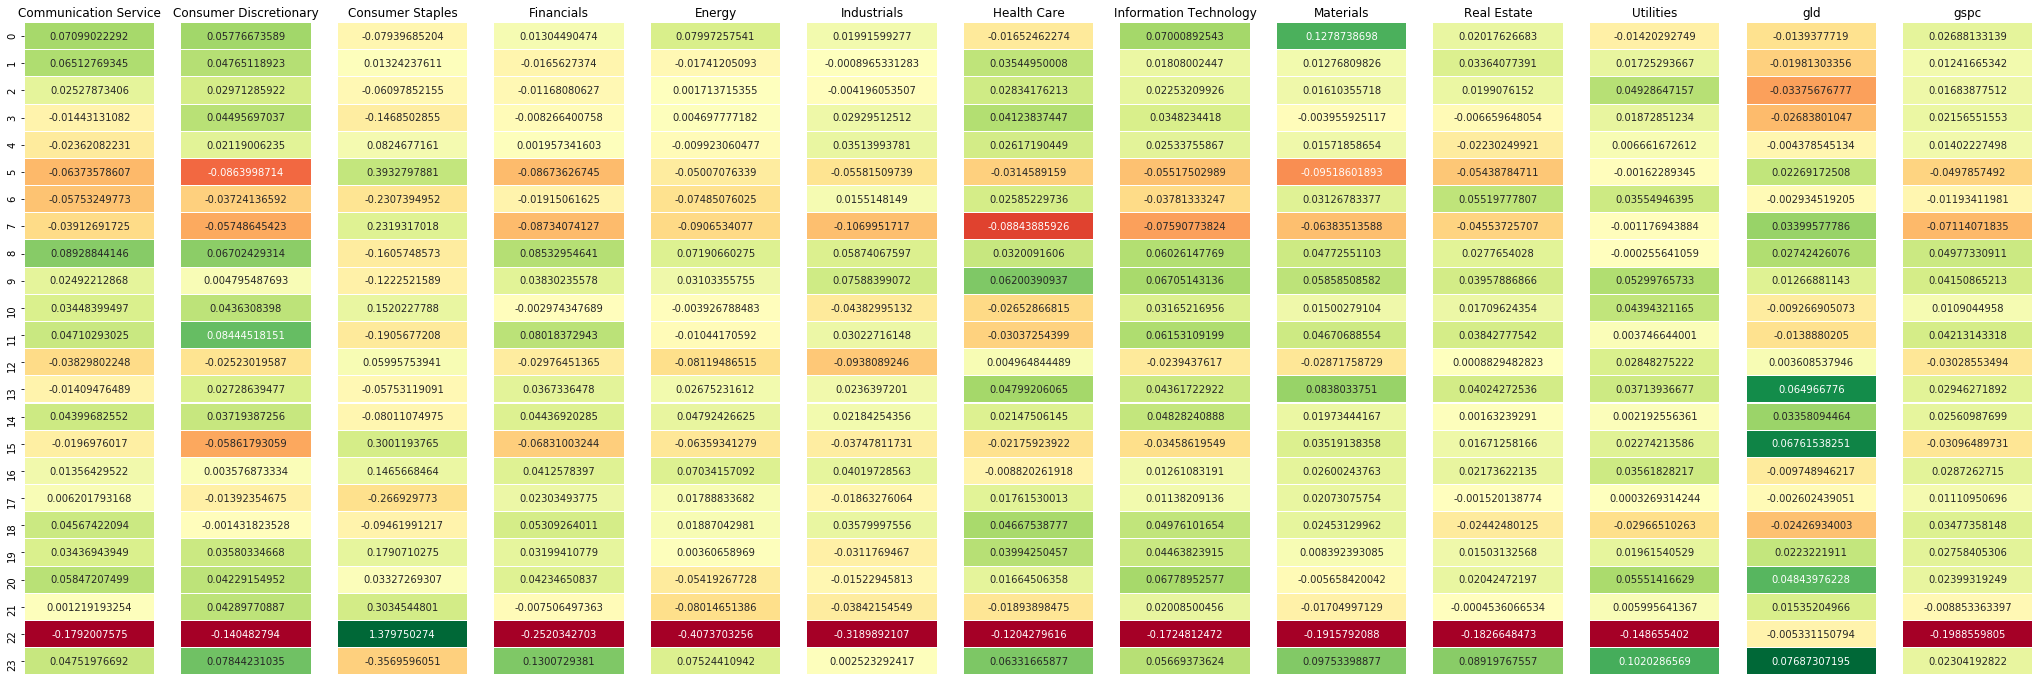

In [5]:
# Generate heat map with each column having its own color scale
# 2018-2020
fig,axes=plt.subplots(figsize = (36,12),ncols=ncols)
sns.heatmap(output_T[[Cols[0]]], linewidths = 0.01, ax = axes[0],cmap=cmaps[0],center=0,annot=True,fmt='.10g',xticklabels=False,cbar=False)
axes[0].set_title(Cols[0])
for i in range(1,ncols):
    sns.heatmap(output_T[[Cols[i]]], linewidths = 0.01, ax = axes[i],cmap=cmaps[i],center=0,annot=True,fmt='.10g',xticklabels=False,yticklabels=False,cbar=False)
    axes[i].set_title(Cols[i])
    axes[i].set_ylabel('')
plt.show()
plt.close()

Part B: 
1. visualize the monthly percentage change of adj_close in 11 sectors and S&P 500 from May, 2017 to April, 2020. Determine months that have the most or least fluctuation among all the sectors and S&P 500. 

In [6]:
# read output.csv
output = pd.read_csv('output.csv')

# drop all NaN
output.dropna(inplace=True)

# rename column names into percetage change of adj_close
# for example, '2017.5' means the percentage change of adj_close from April 2017 to May 2017
output.columns = ['Sector','2017.5','2017.6','2017.7','2017.8','2017.9','2017.10','2017.11','2017.12',
                  '2018.1','2018.2','2018.3','2018.4','2018.5','2018.6','2018.7','2018.8','2018.9','2018.10','2018.11','2018.12',
                  '2019.1','2019.2','2019.3','2019.4','2019.5', '2019.6', '2019.7', '2019.8', '2019.9', '2019.10', '2019.11', '2019.12', 
                  '2020.1', '2020.2', '2020.3', '2020.4']
output = output[['Sector','2018.5','2018.6','2018.7','2018.8','2018.9','2018.10','2018.11','2018.12',
                  '2019.1','2019.2','2019.3','2019.4','2019.5', '2019.6', '2019.7', '2019.8', '2019.9', '2019.10', '2019.11', '2019.12', 
                  '2020.1', '2020.2', '2020.3', '2020.4']]
# set index as sector
output.set_index('Sector', inplace=True)

# drop month
output.drop('month',inplace=True)
output.head()

,2018.5,2018.6,2018.7,2018.8,2018.9,2018.10,2018.11,2018.12,2019.1,2019.2,...,2019.7,2019.8,2019.9,2019.10,2019.11,2019.12,2020.1,2020.2,2020.3,2020.4
Sector,,,,,,,,,,,,,,,,,,,,,
Communication Service,0.070990,0.065128,0.025279,-0.014431,-0.023621,-0.063736,-0.057532,-0.039127,0.089288,0.024922,...,0.043997,-0.019698,0.013564,0.006202,0.045674,0.034369,0.058472,0.001219,-0.179201,0.047520
Consumer Discretionary,0.057767,0.047651,0.029713,0.044957,0.021190,-0.086400,-0.037241,-0.057486,0.067024,0.004795,...,0.037194,-0.058618,0.003577,-0.013924,-0.001432,0.035803,0.042292,0.042898,-0.140483,0.078442
Consumer Staples,-0.079397,0.013242,-0.060979,-0.146850,0.082468,0.393280,-0.230739,0.231932,-0.160575,-0.122252,...,-0.080111,0.300119,0.146567,-0.266930,-0.094620,0.179071,0.033273,0.303454,1.379750,-0.356960
Energy,0.079973,-0.017412,0.001714,0.004698,-0.009923,-0.050071,-0.074851,-0.090653,0.071907,0.031034,...,0.047924,-0.063593,0.070342,0.017888,0.018870,0.003607,-0.054193,-0.080147,-0.407370,0.075244
Financials,0.013045,-0.016563,-0.011681,-0.008266,0.001957,-0.086736,-0.019151,-0.087341,0.085330,0.038302,...,0.044369,-0.068310,0.041258,0.023035,0.053093,0.031994,0.042347,-0.007506,-0.252034,0.130073


In [7]:
# Set up for heat map 
Cols=output.columns[:]# select all columns

ncols = len(Cols)
# The heatmap color scheme depends on the column
# for example, inflation is shown in red, gdp growth in green

cmaps = ["RdYlGn","RdYlGn","RdYlGn","RdYlGn","RdYlGn","RdYlGn","RdYlGn","RdYlGn","RdYlGn","RdYlGn",
         "RdYlGn","RdYlGn","RdYlGn","RdYlGn","RdYlGn","RdYlGn","RdYlGn","RdYlGn","RdYlGn","RdYlGn",
         "RdYlGn","RdYlGn", "RdYlGn","RdYlGn"]



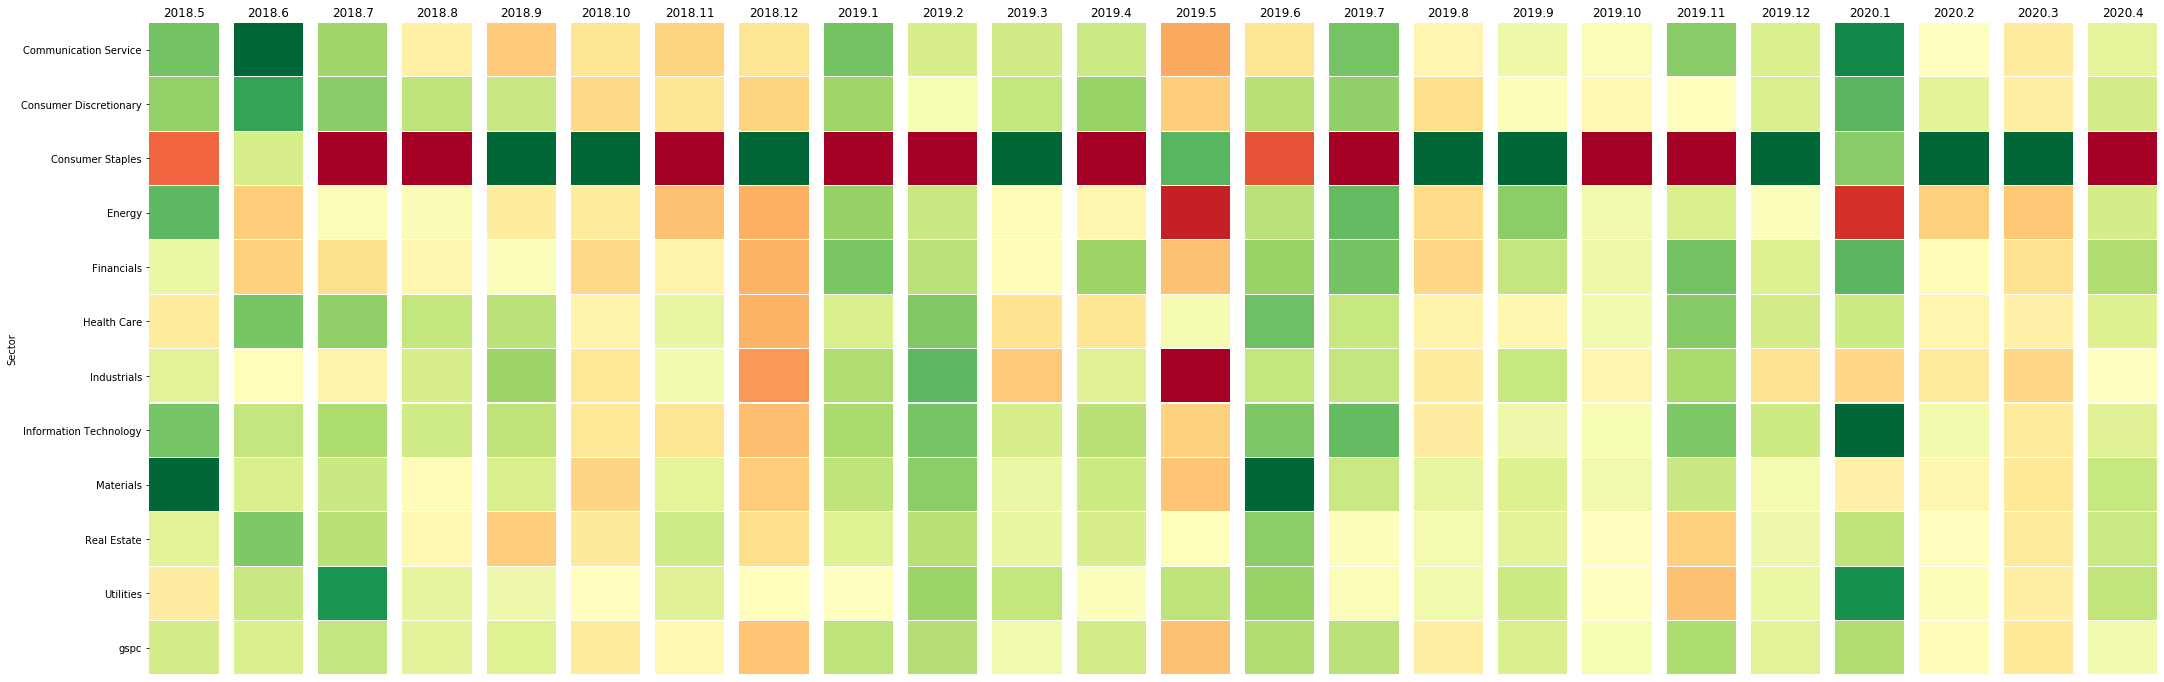

In [8]:
# Generate heat map with each column having its own color scale
fig,axes=plt.subplots(figsize = (36,12),ncols=ncols)
sns.heatmap(output[[Cols[0]]], linewidths = 0.01, ax = axes[0],cmap=cmaps[0],center=0,annot=False,fmt='.10g',xticklabels=False,cbar=False)
axes[0].set_title(Cols[0])
for i in range(1,ncols):
    sns.heatmap(output[[Cols[i]]], linewidths = 0.01, ax = axes[i],cmap=cmaps[i],center=0,annot=False,fmt='.10g',xticklabels=False,yticklabels=False,cbar=False)
    axes[i].set_title(Cols[i])
    axes[i].set_ylabel('')
plt.show()
plt.close()

# 3. Line charts for 11 sectors across the selected period 

Period from 2018.1-2018.4, 2019.1-2019.4, and 2020.1-2020.4

In [9]:
from matplotlib import pyplot as plt
%matplotlib inline

In [11]:
chart = pd.read_csv('temp.csv')
chart.drop([chart.index[0],chart.index[1],chart.index[2],chart.index[3],chart.index[4],chart.index[5],chart.index[6],chart.index[7],chart.index[8]],inplace=True)
chart.reset_index(inplace=True)
chart.drop('index',axis=1,inplace=True)
chart.head()

,year,month,Communication Service,Consumer Discretionary,Consumer Staples,Financials,Energy,Industrials,Health Care,Information Technology,Materials,Real Estate,Utilities,gld,gspc
0,2018,1,0.085619,0.097461,-0.025037,0.060628,0.064392,0.078747,0.068965,0.055127,0.045723,-0.012042,-0.058203,NaN,0.046376
1,2018,2,-0.009114,0.022470,-0.005191,-0.024885,-0.100915,-0.050351,-0.045029,-0.009204,-0.062708,-0.048862,-0.016301,NaN,-0.034834
2,2018,3,0.007590,0.033834,0.041020,0.010780,0.016412,-0.002972,-0.019591,0.033051,-0.020662,0.012664,0.013127,NaN,-0.002095
3,2018,4,-0.036574,-0.006508,-0.005327,-0.029131,0.098218,-0.021598,-0.012819,-0.009286,-0.016650,-0.003179,0.030167,NaN,-0.014517
4,2018,5,0.070990,0.057767,-0.079397,0.013045,0.079973,0.019916,-0.016525,0.070009,0.127874,0.020176,-0.014203,-0.013938,0.026881


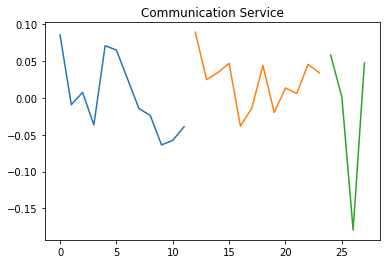

In [12]:
# Communication Service

plt.plot(chart['Communication Service'][0:12])
plt.plot(chart['Communication Service'][12:24])
plt.plot(chart['Communication Service'][-4:])
plt.title('Communication Service',fontdict=None, loc='center', pad=None)
plt.show()

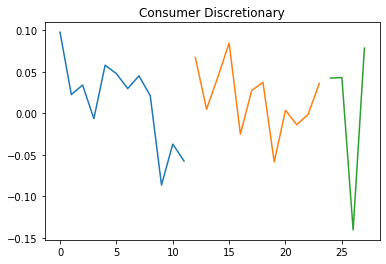

In [13]:
# Consumer Discretionary

plt.plot(chart['Consumer Discretionary'][0:12])
plt.plot(chart['Consumer Discretionary'][12:24])
plt.plot(chart['Consumer Discretionary'][-4:])
plt.title('Consumer Discretionary',fontdict=None, loc='center', pad=None)
plt.show()

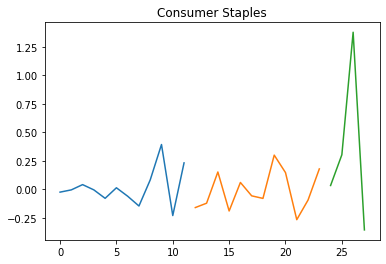

In [14]:
# Consumer Staples

plt.plot(chart['Consumer Staples'][0:12])
plt.plot(chart['Consumer Staples'][12:24])
plt.plot(chart['Consumer Staples'][-4:])
plt.title('Consumer Staples',fontdict=None, loc='center', pad=None)
plt.show()

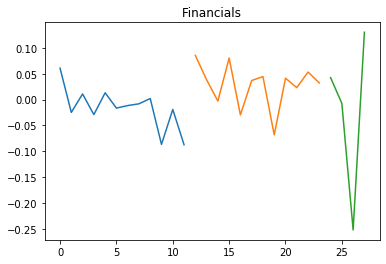

In [15]:
# Financials

plt.plot(chart['Financials'][0:12])
plt.plot(chart['Financials'][12:24])
plt.plot(chart['Financials'][-4:])
plt.title('Financials',fontdict=None, loc='center', pad=None)
plt.show()

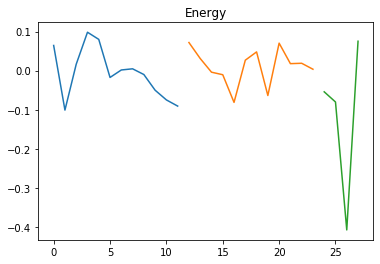

In [16]:
# Energy

plt.plot(chart['Energy'][0:12])
plt.plot(chart['Energy'][12:24])
plt.plot(chart['Energy'][-4:])
plt.title('Energy',fontdict=None, loc='center', pad=None)
plt.show()

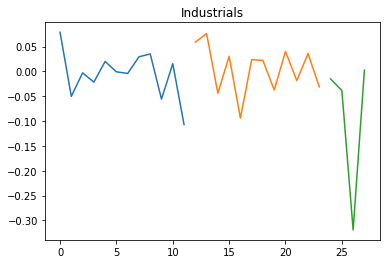

In [17]:
# Industrials

plt.plot(chart['Industrials'][0:12])
plt.plot(chart['Industrials'][12:24])
plt.plot(chart['Industrials'][-4:])
plt.title('Industrials',fontdict=None, loc='center', pad=None)
plt.show()

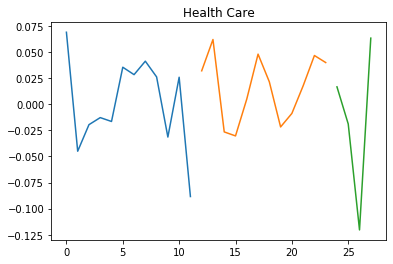

In [18]:
# Health Care

plt.plot(chart['Health Care'][0:12])
plt.plot(chart['Health Care'][12:24])
plt.plot(chart['Health Care'][-4:])
plt.title('Health Care',fontdict=None, loc='center', pad=None)
plt.show()

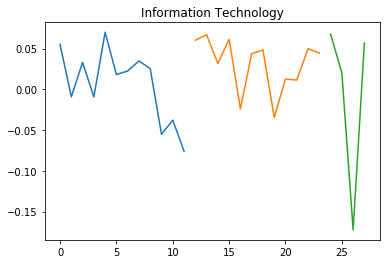

In [19]:
# Information Technology

plt.plot(chart['Information Technology'][0:12])
plt.plot(chart['Information Technology'][12:24])
plt.plot(chart['Information Technology'][-4:])
plt.title('Information Technology',fontdict=None, loc='center', pad=None)
plt.show()

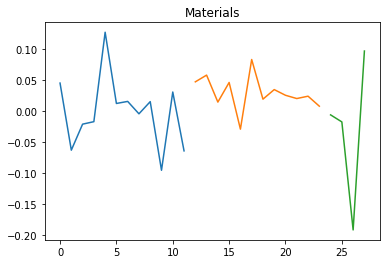

In [20]:
# Materials

plt.plot(chart['Materials'][0:12])
plt.plot(chart['Materials'][12:24])
plt.plot(chart['Materials'][-4:])
plt.title('Materials',fontdict=None, loc='center', pad=None)
plt.show()

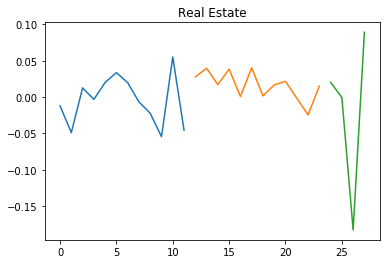

In [21]:
# Real Estate

plt.plot(chart['Real Estate'][0:12])
plt.plot(chart['Real Estate'][12:24])
plt.plot(chart['Real Estate'][-4:])
plt.title('Real Estate',fontdict=None, loc='center', pad=None)
plt.show()

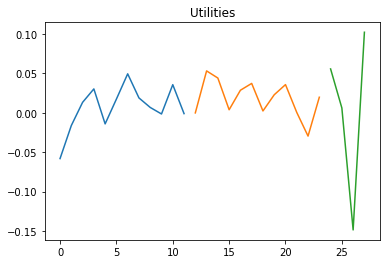

In [22]:
# Utilities

plt.plot(chart['Utilities'][0:12])
plt.plot(chart['Utilities'][12:24])
plt.plot(chart['Utilities'][-4:])
plt.title('Utilities',fontdict=None, loc='center', pad=None)
plt.show()

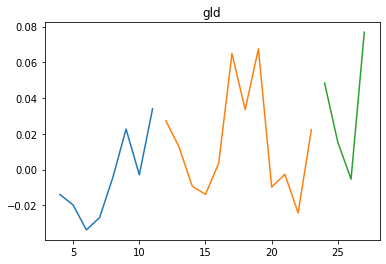

In [23]:
# GOLD,GLD

plt.plot(chart['gld'][0:12])
plt.plot(chart['gld'][12:24])
plt.plot(chart['gld'][-4:])
plt.title('gld',fontdict=None, loc='center', pad=None)

plt.show()